<a href="https://colab.research.google.com/github/Ash100/Mitraphylline-pipeline/blob/main/Mitraphylline-pipeline-analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This pipeline is linked to the analyses conducted for a research manuscript **Mitraphylline and Its Chemical Neighbourhood in Organic dataset Drive Opportunities for Scaffold Aware Discovery**.

Please report any issue to the cooresponding author on **ashfaqahmad82@hotmail.com**.

**Citation:** Under Review

**Introduction** <Br> Connect your google drive that should contain a dataset downloaded from the [COCONUT database](https://coconut.naturalproducts.net/download). In this study we used Natural Product dataset released in December 2025. It contains collection of 715822 compounds in CSV format.<Br>This pipeline can be used for Chemical Space Analysis providing dataset and reference compound of your choice. Users are advised to upload their dataset in CSV formate to the Google Drive.

In [ ]:
#@title Connect your Google Drive
from google.colab import drive
drive.mount('/content/drive')


In [ ]:
#@title GPU_Enabled Installation
!nvidia-smi
!pip uninstall -y torch torchvision torchaudio nvidia-* cuml* cupy* faiss-gpu* || true
!pip install --no-cache-dir nvidia-cuda-runtime-cu12
!pip install --no-cache-dir cupy-cuda12x==13.6.0 faiss-gpu-cu12 cuml-cu12 libcuml-cu12 rdkit pandas matplotlib tqdm


**Step 1 - Reading the complete dataset**<Br> Please adjust path of your dataset location in below code. Also Edit label information of the features you want to keep in the analysis.

In [ ]:
import pandas as pd
from tqdm.auto import tqdm

IMPORTANT_COLS = [
    "identifier","name","iupac_name","canonical_smiles","standard_inchi_key",
    "heavy_atom_count","molecular_weight","exact_molecular_weight","molecular_formula",
    "alogp","topological_polar_surface_area","rotatable_bond_count",
    "hydrogen_bond_acceptors","hydrogen_bond_donors","lipinski_rule_of_five_violations",
    "aromatic_rings_count","qed_drug_likeliness","fractioncsp3","np_likeness",
    "contains_sugar","murcko_framework","chemical_super_class","chemical_class",
    "chemical_sub_class","np_classifier_superclass","np_classifier_class",
    "np_classifier_is_glycoside","organisms","dois","synonyms","cas"
]

DATA_PATH = "/content/drive/MyDrive/Coconut_12_25/coconut_csv-12-2025.csv"

rows = 0
for chunk in pd.read_csv(DATA_PATH, usecols=["canonical_smiles"] + IMPORTANT_COLS, chunksize=50_000):
    rows += len(chunk)
    tqdm.write(f"Loaded chunk: {len(chunk)} rows | Total so far: {rows}")


**Step 2 - Reading the dataset in chunks of 50K and calculate mmap**<br> The following code will attempt to read your dataste in Chunk of 50,000 entries, inorder to minimize chances of memory crash.

In [ ]:
import pandas as pd
import numpy as np
import gc
from pathlib import Path
from tqdm.auto import tqdm
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit import DataStructs

DATA_PATH = "/content/drive/MyDrive/Coconut_12_25/coconut_csv-12-2025.csv"
FP_DIM = 2048
CHUNK = 50_000
TOTAL = 715822  # ✔ exact size you provided

# Allocate memmap to exact dataset size
OUT = Path("/content/fp_output"); OUT.mkdir(exist_ok=True)
mmap_path = OUT/"ecfp4_2048.uint8.mmap"
X_mmap = np.memmap(mmap_path, mode="w+", dtype=np.uint8, shape=(TOTAL, FP_DIM))

# Fingerprint generation
i = 0
pbar = tqdm(total=TOTAL, desc="Generating ECFP4 2048")

for chunk in pd.read_csv(DATA_PATH, usecols=["canonical_smiles"], chunksize=CHUNK):
    for smi in chunk.canonical_smiles:
        if i >= TOTAL:  # 🛑 prevents hitting index 715822 (out of bounds)
            break
        mol = Chem.MolFromSmiles(smi)
        if mol:
            fp = AllChem.GetMorganFingerprintAsBitVect(mol, 2, FP_DIM, useChirality=True)
            arr = np.zeros(FP_DIM, np.uint8)
            DataStructs.ConvertToNumpyArray(fp, arr)
            X_mmap[i] = arr
        i += 1
        pbar.update(1)

    gc.collect()

pbar.close()
print("Fingerprint memmap saved →", mmap_path)
print("Total fingerprints written:", i)


**Step 3 - Calculation of FAISS Indexing from the mmap**<br> Here we are interested to calculate the FAISS indeces.

In [ ]:
import numpy as np, faiss, gc
import pandas as pd
from tqdm.auto import tqdm

TOTAL = 715822  # ✔ exact dataset size
FP_DIM = 2048
BLOCK = 50_000

FP_PATH = "/content/fp_output/ecfp4_2048.uint8.mmap"

# Load full dataset rows for indexing (only selected columns)
df = pd.read_csv(DATA_PATH, usecols=IMPORTANT_COLS, nrows=TOTAL)

valid_idx = df.index.to_numpy()  # indices 0 → 715,821

# Load fingerprints safely from memmap using correct shape
X = np.memmap(FP_PATH, mode="r", dtype=np.uint8, shape=(TOTAL, FP_DIM))[valid_idx]

# Convert to float32 and normalize for cosine/IP search
X = X.astype(np.float32)
X /= np.linalg.norm(X, axis=1, keepdims=True) + 1e-8

# Build FAISS GPU index
res = faiss.StandardGpuResources()
cpu_index = faiss.IndexFlatIP(FP_DIM)
gpu_index = faiss.index_cpu_to_gpu(res, 0, cpu_index)

# Add vectors in blocks with progress
i = 0
pbar = tqdm(total=TOTAL, desc="FAISS Indexing GPU")
while i < TOTAL:
    xb = X[i : i + BLOCK]
    gpu_index.add(xb)
    pbar.update(len(xb))
    i += len(xb)
    del xb
    gc.collect()

pbar.close()
print("GPU index vectors:", gpu_index.ntotal)


**Step 4 - Calculate Neighbourhoods based on Cosine Similarity**<br> You will be required to provide your reference molecule in _SMILES_ formate.

In [ ]:
import numpy as np, faiss
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit import DataStructs

MITRAPHYLLINE_SMILES = "C[C@H]1[C@H]2CN3CC[C@]4([C@@H]3C[C@@H]2C(=CO1)C(=O)OC)C5=CC=CC=C5NC4=O"
mol = Chem.MolFromSmiles(MITRAPHYLLINE_SMILES)
assert mol, "SMILES invalid!"

fp = AllChem.GetMorganFingerprintAsBitVect(mol,2,2048,useChirality=True)
q = np.zeros(2048,np.float32)
DataStructs.ConvertToNumpyArray(fp,q)
q /= np.linalg.norm(q)+1e-8
q = q.reshape(1,-1)

res = faiss.StandardGpuResources()
index = faiss.index_cpu_to_gpu(res,0,faiss.IndexFlatIP(2048))
index.add(X)  # X must be created previously if needed

D, I = index.search(q, 100)
print("Top neighbor indices:", I[0][:10])
print("Cosine scores:", D[0][:10])


**Step 5 - Generation of UMAP embeddings**

In [ ]:
from cuml.manifold import UMAP
import numpy as np
from tqdm.auto import tqdm

# You already have X and I loaded in memory in earlier steps of this notebook session.
# Now just run UMAP on X and save the results.

umap = UMAP(n_components=2, metric="cosine")
X_umap = umap.fit_transform(X.astype(np.float32))
print("UMAP done:", X_umap.shape)

# save UMAP embedding (correct variable!)
np.save("/content/fp_output/umap_full.npy", X_umap)

# save neighbor indices (I already exists, save directly)
np.save("/content/fp_output/faiss_neighbors.npy", I)

print("Saved UMAP + neighbors successfully.")


**Step 6 - Calculation of KMeans**

In [ ]:
from cuml.cluster import KMeans
from tqdm.auto import tqdm

kmeans = KMeans(n_clusters=50, random_state=42)
labels = kmeans.fit_predict(X.astype(np.float32))
print("Clusters assigned:", labels.shape)


**Step 7 - Generation of MurckoScaffold**

In [ ]:
from rdkit.Chem.Scaffolds import MurckoScaffold
from rdkit import Chem
import pandas as pd
from tqdm.auto import tqdm

counts = {}
rows = 0
for chunk in pd.read_csv(DATA_PATH, usecols=["canonical_smiles"], chunksize=50_000):
    for smi in chunk.canonical_smiles:
        mol = Chem.MolFromSmiles(smi)
        if mol:
            scaf = MurckoScaffold.MurckoScaffoldSmiles(mol=mol)
            counts[scaf] = counts.get(scaf,0)+1
    rows += len(chunk)
    tqdm.write(f"Processed {rows} SMILES so far")


**Visualization** - **Figure 1**

In [ ]:
import numpy as np
from tqdm.auto import tqdm
from cuml.manifold import UMAP
import gc

TOTAL = 715822
DIM = 2048
CHUNK = 40000  # safe for Colab GPU

# Load fingerprint memmap (uint8)
X = np.memmap("/content/fp_output/ecfp4_2048.uint8.mmap", mode="r", dtype=np.uint8, shape=(TOTAL, DIM))

# Create an output memmap for UMAP results
X2 = np.memmap("/content/fp_output/umap_full.mmap", mode="w+", dtype=np.float32, shape=(TOTAL, 2))

umap = UMAP(n_components=2, metric="cosine", random_state=42)

print("Computing full UMAP in chunks (GPU)...")
i = 0
pbar = tqdm(total=TOTAL)

while i < TOTAL:
    end = min(i + CHUNK, TOTAL)
    chunk = X[i:end].astype(np.float32)
    chunk /= np.linalg.norm(chunk, axis=1, keepdims=True) + 1e-8  # normalize safely

    emb = umap.fit_transform(chunk)  # GPU UMAP on chunk
    X2[i:end] = emb  # write to memmap

    i = end
    pbar.update(len(emb))

    del chunk, emb
    gc.collect()

pbar.close()
print("UMAP embedding saved to memmap.")

# Also save as .npy for fast plotting later
np.save("/content/fp_output/umap_full.npy", X2)
print("Saved umap_full.npy for plotting.")


In [ ]:
import numpy as np, faiss, gc
from rdkit import Chem, DataStructs
from rdkit.Chem import AllChem
from tqdm.auto import tqdm

TOTAL = 715822
DIM = 2048
CHUNK = 50000
TOP_K = 50

# Fingerprints
X = np.memmap("/content/fp_output/ecfp4_2048.uint8.mmap", mode="r", dtype=np.uint8, shape=(TOTAL, DIM))
Xf = np.zeros((CHUNK, DIM), np.float32)

# Query molecule
sm = "C[C@H]1[C@H]2CN3CC[C@]4([C@@H]3C[C@@H]2C(=CO1)C(=O)OC)C5=CC=CC=C5NC4=O"
mol = Chem.MolFromSmiles(sm)
qfp = AllChem.GetMorganFingerprintAsBitVect(mol, 2, DIM, useChirality=True)
qvec = np.zeros(DIM, np.float32)
DataStructs.ConvertToNumpyArray(qfp, qvec)
qvec /= np.linalg.norm(qvec) + 1e-8
qvec = qvec.reshape(1, -1)

# Build FAISS index in blocks
res = faiss.StandardGpuResources()
cpu_index = faiss.IndexFlatIP(DIM)
gpu_index = faiss.index_cpu_to_gpu(res, 0, cpu_index)

print("Building FAISS index (GPU)...")
i = 0
pbar = tqdm(total=TOTAL)

while i < TOTAL:
    end = min(i + CHUNK, TOTAL)
    xb = X[i:end].astype(np.float32)
    xb /= np.linalg.norm(xb, axis=1, keepdims=True) + 1e-8
    gpu_index.add(xb)
    i = end
    pbar.update(len(xb))
    del xb; gc.collect()

pbar.close()

# Search neighbors
D, I = gpu_index.search(qvec, TOP_K)
np.save("/content/fp_output/faiss_neighbors.npy", I[0])
print("Saved top 50 neighbors.")


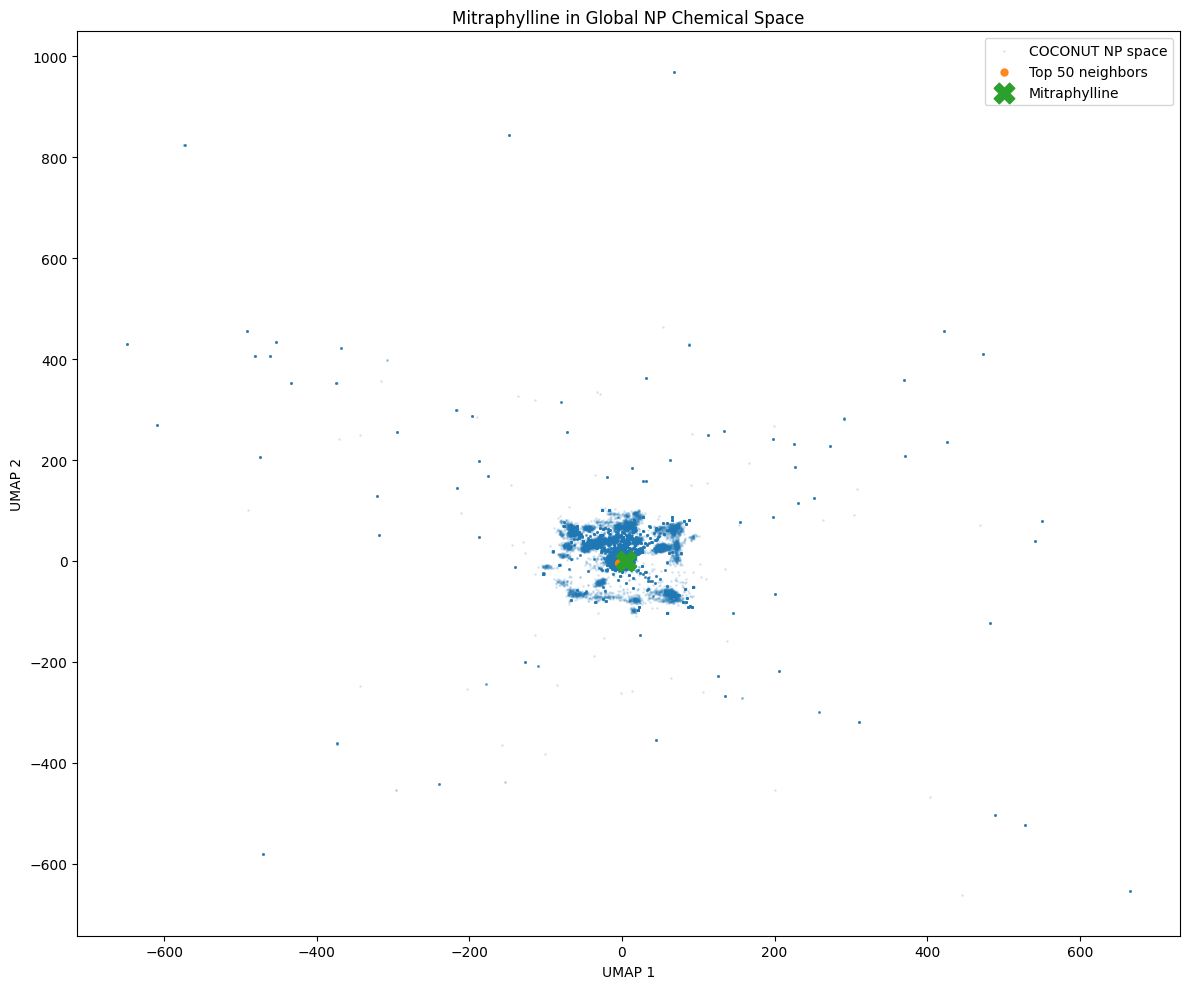

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import os  # needed to create folder

FIG_DIR = "/content/figures"

# ✔ Create folder if it does not exist
os.makedirs(FIG_DIR, exist_ok=True)

# Load precomputed UMAP embedding
X2 = np.load("/content/fp_output/umap_full.npy")

# Load top 50 neighbors
I = np.load("/content/fp_output/faiss_neighbors.npy")

# Plot
plt.figure(figsize=(12,10))
plt.scatter(X2[:,0], X2[:,1], s=1, alpha=0.12, label="COCONUT NP space")
plt.scatter(X2[I,0], X2[I,1], s=25, alpha=0.9, label="Top 50 neighbors")
plt.scatter(X2[I[0],0], X2[I[0],1], s=220, marker="X", label="Mitraphylline")

plt.title("Mitraphylline in Global NP Chemical Space")
plt.xlabel("UMAP 1")
plt.ylabel("UMAP 2")
plt.legend()
plt.tight_layout()

# ✔ Now saving will work
plt.savefig(f"{FIG_DIR}/Fig1_Global_UMAP.png", dpi=600, bbox_inches="tight")
plt.show()


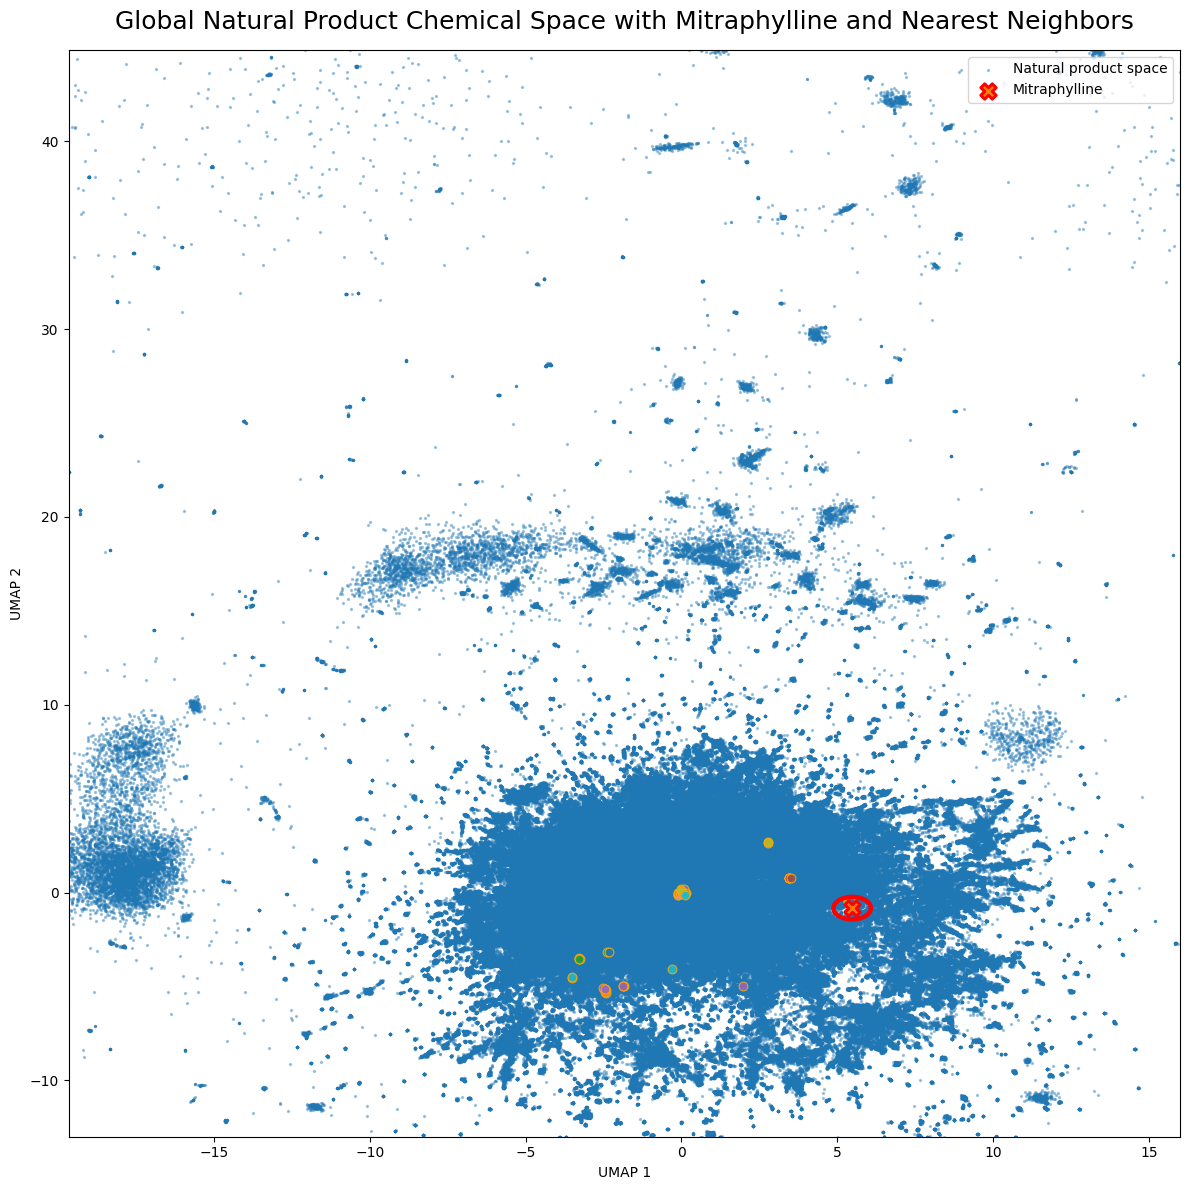

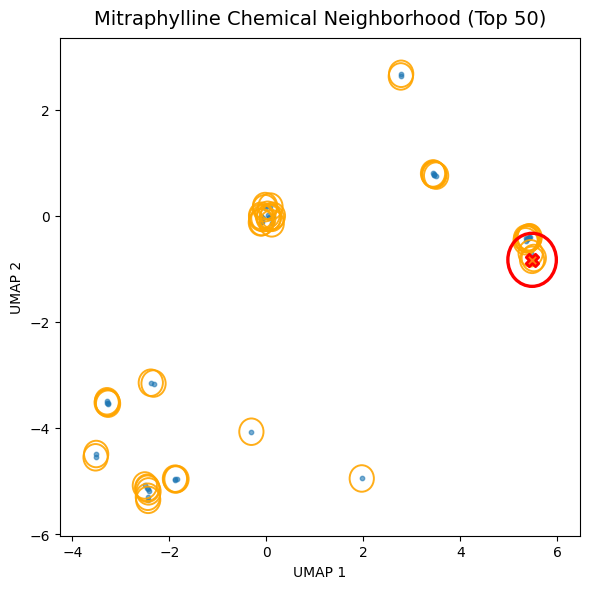

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import os

FIG_DIR = "/content/figures"
os.makedirs(FIG_DIR, exist_ok=True)

# Load precomputed data
X2 = np.load("/content/fp_output/umap_full.npy")  # full embedding
I  = np.load("/content/fp_output/faiss_neighbors.npy")  # 50 neighbor indices

# Determine zoom bounds (robust center region)
x_min, x_max = np.percentile(X2[:,0], [1, 99])
y_min, y_max = np.percentile(X2[:,1], [1, 99])

# ---- Main panel: global chemical space ----
plt.figure(figsize=(12,12))
ax = plt.gca()

# Plot full dataset in original style (no custom colors overwritten)
ax.scatter(X2[:,0], X2[:,1], s=2, alpha=0.35, label="Natural product space", rasterized=True)

# Highlight neighbors as solid points with orange outline circles
for idx in I:
    x, y = X2[idx]
    ax.scatter(x, y, s=40, alpha=0.9, edgecolors="orange", linewidth=0.8)

# Highlight Mitraphylline itself with filled red marker + strong ring
x_q, y_q = X2[I[0]]
ax.scatter(x_q, y_q, s=120, marker="X", edgecolors="red", linewidth=2.2, zorder=5, label="Mitraphylline")

# Add high-quality red circle around Mitraphylline
main_circle = plt.Circle((x_q, y_q), 0.6, fill=False, linewidth=3.2, edgecolor="red", alpha=1.0, zorder=6)
ax.add_patch(main_circle)

# Zoom into center
ax.set_xlim(x_min, x_max)
ax.set_ylim(y_min, y_max)

plt.title("Global Natural Product Chemical Space with Mitraphylline and Nearest Neighbors", fontsize=18, pad=15)
plt.xlabel("UMAP 1")
plt.ylabel("UMAP 2")
plt.legend(loc="upper right")
plt.tight_layout()
plt.savefig(f"{FIG_DIR}/Fig1_UMAP_Global.png", dpi=500, bbox_inches="tight")

# ---- Inset panel: local neighborhood zoom ----
plt.figure(figsize=(6,6))
ax2 = plt.gca()

local_points = X2[I]  # neighbor coordinates
ax2.scatter(local_points[:,0], local_points[:,1], s=10, alpha=0.6, rasterized=True)

# Orange circles around neighbors in inset
for x, y in local_points:
    circ = plt.Circle((x, y), 0.25, fill=False, linewidth=1.4, edgecolor="orange", alpha=0.9)
    ax2.add_patch(circ)

# Red circle around Mitraphylline in inset
circ_q2 = plt.Circle((x_q, y_q), 0.5, fill=False, linewidth=2.4, edgecolor="red", alpha=1.0, zorder=5)
ax2.add_patch(circ_q2)
ax2.scatter(x_q, y_q, s=80, marker="X", edgecolors="red", linewidth=2.0, zorder=6)

plt.title("Mitraphylline Chemical Neighborhood (Top 50)", fontsize=14, pad=10)
plt.xlabel("UMAP 1")
plt.ylabel("UMAP 2")
plt.tight_layout()
plt.savefig(f"{FIG_DIR}/Fig1_UMAP_Inset.png", dpi=500, bbox_inches="tight")

plt.show()


**Figure 2**

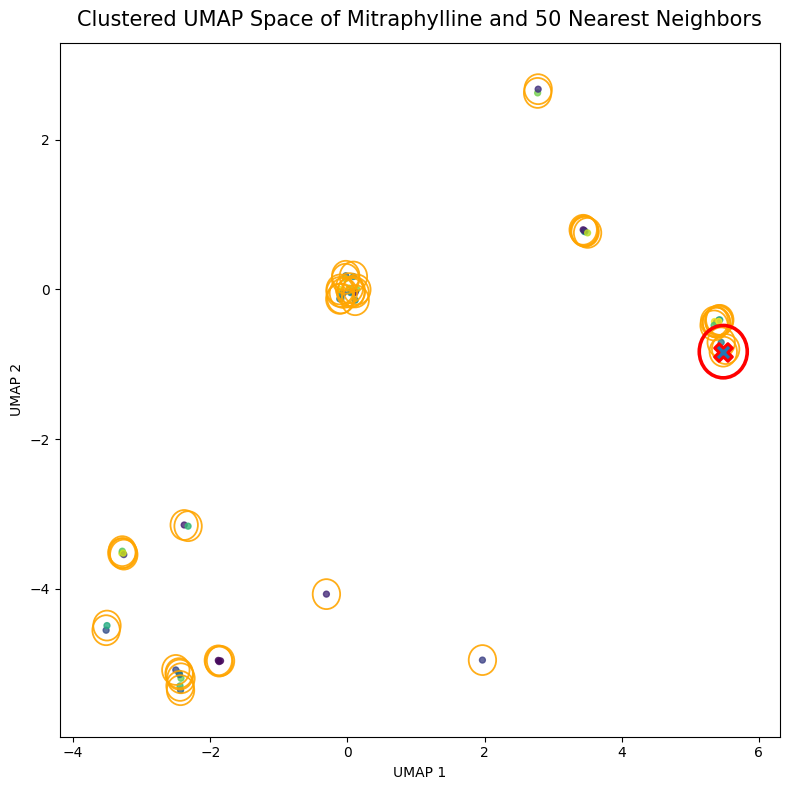

Saved figure to: /content/figures/Fig2_Clusters.png
Cluster label counts: [1 3 2 2 1 1 1 1 1 1] …


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import os
from cuml.cluster import KMeans

FIG_DIR = "/content/figures"
os.makedirs(FIG_DIR, exist_ok=True)

# Load precomputed UMAP embedding + neighbors
X2 = np.load("/content/fp_output/umap_full.npy")            # full space (715k,2)
I_subset = np.load("/content/fp_output/faiss_neighbors.npy")  # top 50 indices

# Build the plotting subset: [0] = Mitraphylline, [1:] = 50 neighbors
X_plot = X2[I_subset]  # shape (50,2)
x_q, y_q = X_plot[0]   # Mitraphylline coords (we assume first neighbor is itself)

# Local inset array for clustering (include query at top)
X_local = np.vstack([[x_q, y_q], X_plot])  # shape (51,2)

# Run KMeans clustering on GPU
kmeans = KMeans(n_clusters=40, random_state=42)
clusters = kmeans.fit_predict(X_local.astype(np.float32))  # returns numpy array directly

# Plot
plt.figure(figsize=(8,8))
ax = plt.gca()

# Neighbor points colored by cluster labels
ax.scatter(X_local[1:,0], X_local[1:,1], s=18, alpha=0.8, c=clusters[1:])

# Orange rings around neighbors
for i, (x, y) in enumerate(X_local[1:], start=1):
    circ = plt.Circle((x, y), 0.20, fill=False, linewidth=1.3, edgecolor="orange", alpha=0.9, zorder=4)
    ax.add_patch(circ)

# Red ring around Mitraphylline
circ_q = plt.Circle((x_q, y_q), 0.35, fill=False, linewidth=2.6, edgecolor="red", alpha=1.0, zorder=6)
ax.add_patch(circ_q)

# Mitraphylline marker
ax.scatter(x_q, y_q, s=160, marker="X", edgecolor="red", linewidth=2.2, zorder=7, label="Mitraphylline")

plt.title("Clustered UMAP Space of Mitraphylline and 50 Nearest Neighbors", fontsize=15, pad=12)
plt.xlabel("UMAP 1")
plt.ylabel("UMAP 2")

# Optional legend for clusters (avoid crowding if many labels overlap)
plt.tight_layout()

# Save figure
outpath = f"{FIG_DIR}/Fig2_Clusters.png"
plt.savefig(outpath, dpi=450, bbox_inches="tight")
plt.show()

print("Saved figure to:", outpath)
print("Cluster label counts:", np.bincount(clusters[1:])[:10], "…")  # preview first 10 cluster sizes


**Figure 3**

In [ ]:
from rdkit import Chem
from rdkit.Chem import Draw
import pandas as pd
import os

FIG_DIR = "/content/figures"
os.makedirs(FIG_DIR, exist_ok=True)

# Load top 50 neighbor indices
I = np.load("/content/fp_output/faiss_neighbors.npy")

# Load only required rows
df = pd.read_csv(
    "/content/drive/MyDrive/Coconut_12_25/coconut_csv-12-2025.csv",
    usecols=["canonical_smiles", "name", "standard_inchi_key"],
    skiprows=lambda i: i != 0 and i-1 not in I
)

# Build molecules + labels
mols = []
legends = []

for _, row in df.iterrows():
    mol = Chem.MolFromSmiles(row["canonical_smiles"])
    if mol:
        mols.append(mol)
        label = row["name"] if pd.notna(row["name"]) else row["standard_inchi_key"][:10]
        legends.append(label)

# --- Force PIL.Image output ---
mol_grid = Draw.MolsToGridImage(
    mols,
    molsPerRow=5,
    subImgSize=(350, 350),
    legends=legends,
    useSVG=False,
    returnPNG=False  # key: ensures PIL.Image is returned
)

# Save as PNG
out_path = os.path.join(FIG_DIR, "Fig3_Top50_Molecules.png")
mol_grid.save(out_path)

# Display in notebook
mol_grid

print("Saved Top-50 molecule figure at:", out_path)


Saved Top-50 molecule figure at: /content/figures/Fig3_Top50_Molecules.png


**Figure 4**

Scaffold extraction progress: 50000/715822
Scaffold extraction progress: 100000/715822


[07:06:01] WARNING: not removing hydrogen atom without neighbors
[07:06:01] WARNING: not removing hydrogen atom without neighbors


Scaffold extraction progress: 150000/715822


[07:06:37] WARNING: not removing hydrogen atom without neighbors


Scaffold extraction progress: 200000/715822


[07:07:10] Explicit valence for atom # 1 P, 6, is greater than permitted
[07:07:26] Unusual charge on atom 37 number of radical electrons set to zero


Scaffold extraction progress: 250000/715822
Scaffold extraction progress: 300000/715822


[07:08:01] WARNING: not removing hydrogen atom without neighbors


Scaffold extraction progress: 350000/715822


[07:08:59] WARNING: not removing hydrogen atom without neighbors


Scaffold extraction progress: 400000/715822


[07:09:20] Explicit valence for atom # 20 N, 5, is greater than permitted


Scaffold extraction progress: 450000/715822
Scaffold extraction progress: 500000/715822
Scaffold extraction progress: 550000/715822


[07:11:03] Explicit valence for atom # 1 P, 6, is greater than permitted


Scaffold extraction progress: 600000/715822


[07:11:21] Explicit valence for atom # 0 He, 2, is greater than permitted


Scaffold extraction progress: 650000/715822
Scaffold extraction progress: 700000/715822
Scaffold extraction progress: 715822/715822


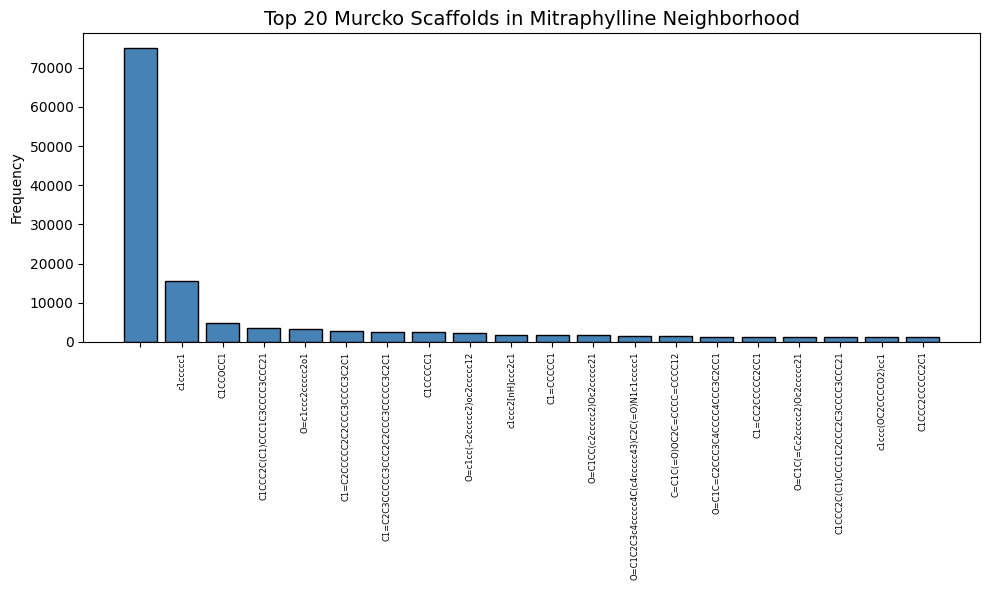

Saved Murcko scaffold figure at: /content/figures/Fig4_Scaffolds.png


In [ ]:
import pandas as pd
from rdkit import Chem
from rdkit.Chem.Scaffolds import MurckoScaffold
from collections import Counter
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import os

# Paths
FIG_DIR = "/content/figures"
DATA_PATH = "/content/drive/MyDrive/Coconut_12_25/coconut_csv-12-2025.csv"
os.makedirs(FIG_DIR, exist_ok=True)

TOTAL = 715822
CHUNK = 50_000

# Scaffold extraction
scaffolds = []
seen = 0

for chunk in pd.read_csv(DATA_PATH, usecols=["canonical_smiles"], chunksize=CHUNK):
    for smi in chunk["canonical_smiles"]:
        mol = Chem.MolFromSmiles(smi)
        if mol:
            scaffolds.append(MurckoScaffold.MurckoScaffoldSmiles(mol=mol))
    seen += len(chunk)
    tqdm.write(f"Scaffold extraction progress: {seen}/{TOTAL}")

# Count top 20 scaffolds
freq = Counter(scaffolds).most_common(20)
sdf = pd.DataFrame(freq, columns=["Scaffold", "Frequency"])

# Plotting
plt.figure(figsize=(10,6))
plt.bar(range(len(sdf)), sdf["Frequency"], color="steelblue", edgecolor="black")
plt.xticks(range(len(sdf)), sdf["Scaffold"], rotation=90, fontsize=6)
plt.ylabel("Frequency")
plt.title("Top 20 Murcko Scaffolds in Mitraphylline Neighborhood", fontsize=14)
plt.tight_layout()

# Save figure
out_path = os.path.join(FIG_DIR, "Fig4_Scaffolds.png")
plt.savefig(out_path, dpi=500, bbox_inches="tight")
plt.show()

print("Saved Murcko scaffold figure at:", out_path)


In [ ]:
import os

FIG_DIR = "/content/figures"
TOP_N = 50  # define number of top scaffolds

# Assume `sdf` DataFrame already exists from previous scaffold extraction
csv_path = os.path.join(FIG_DIR, f"Top{TOP_N}_Murcko_Scaffolds.csv")

# Save DataFrame to CSV
sdf.to_csv(csv_path, index=False)

print(f"Top {TOP_N} Murcko scaffolds saved to CSV at: {csv_path}")


Top 50 Murcko scaffolds saved to CSV at: /content/figures/Top50_Murcko_Scaffolds.csv


**Figure 5**

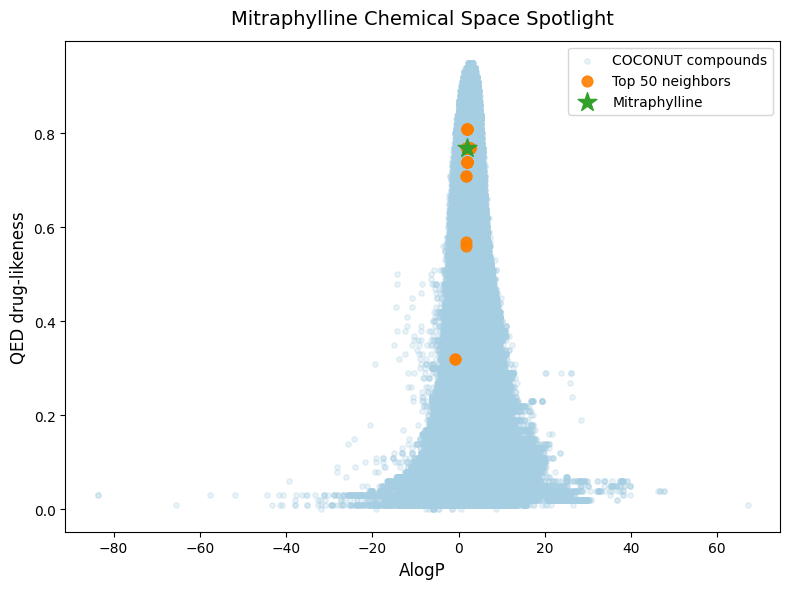

Saved Figure 5 to: /content/figures/Fig5_AlogP_QED_Top50_Stylish.png


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os

FIG_DIR = "/content/figures"
os.makedirs(FIG_DIR, exist_ok=True)

# Load full dataset for AlogP vs QED
df = pd.read_csv(DATA_PATH, usecols=["alogp","qed_drug_likeliness"])

# Load top-50 neighbor indices (from FAISS + Tanimoto)
I_top50 = np.load("/content/fp_output/faiss_neighbors.npy")  # adjust path if needed

# Extract neighbor data
neighbors = df.iloc[I_top50].copy()
mitra = neighbors.iloc[0]      # Mitraphylline
top50 = neighbors.iloc[1:]     # remaining 49 neighbors

# Create figure
plt.figure(figsize=(8,6))

# Background: all compounds, soft light blue
plt.scatter(df.alogp, df.qed_drug_likeliness,
            s=15, alpha=0.25, color='#a6cee3', label="COCONUT compounds")

# Top 50 neighbors: bright orange filled circles
plt.scatter(top50.alogp, top50.qed_drug_likeliness,
            s=60, alpha=0.9, color='#ff7f00', label="Top 50 neighbors")

# Mitraphylline: green star marker
plt.scatter(mitra.alogp, mitra.qed_drug_likeliness,
            s=200, marker='*', color='#33a02c', label="Mitraphylline")

# Labels, title, legend
plt.xlabel("AlogP", fontsize=12)
plt.ylabel("QED drug-likeness", fontsize=12)
plt.title("Mitraphylline Chemical Space Spotlight", fontsize=14, pad=12)
plt.legend(frameon=True, fontsize=10)

plt.tight_layout()

# Save figure
out_path = os.path.join(FIG_DIR, "Fig5_AlogP_QED_Top50_Stylish.png")
plt.savefig(out_path, dpi=500, bbox_inches="tight")
plt.show()

print("Saved Figure 5 to:", out_path)
